In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import interp1d
import seaborn as sns
import os

from ClassFunctions import precip_time_series, rainfall_analysis

## Create object containing rainfall events for one gauge

In [2]:
file = '/nfs/a319/gy17m2a/PhD/datadir/DanishRainData/501520_edited.csv'
ts = precip_time_series(file)
ts.pad_and_resample('5min')
analysis = rainfall_analysis('1h', ts)
    #analysis.get_metrics()
    #df = pd.DataFrame(analysis.metrics)
    #all_events.append(df)
# all_events_df = pd.concat(all_events)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 474555/474555 [02:56<00:00, 2692.84it/s]


In [ ]:
# all_events = []
# for file in os.listdir("/nfs/a319/gy17m2a/PhD/datadir/DanishRainData")[0:1]:
#     print(file)
#     if 'edited' in file:
#         print(f"/nfs/a319/gy17m2a/PhD/datadir/DanishRainData/{file}")
#         ts = precip_time_series(f"/nfs/a319/gy17m2a/PhD/datadir/DanishRainData/{file}")
#         ts.pad_and_resample('5min')
#         analysis = rainfall_analysis('5h', ts)
        #analysis.get_metrics()
        #df = pd.DataFrame(analysis.metrics)
        #all_events.append(df)
# all_events_df = pd.concat(all_events)

## Create Correlation matrix

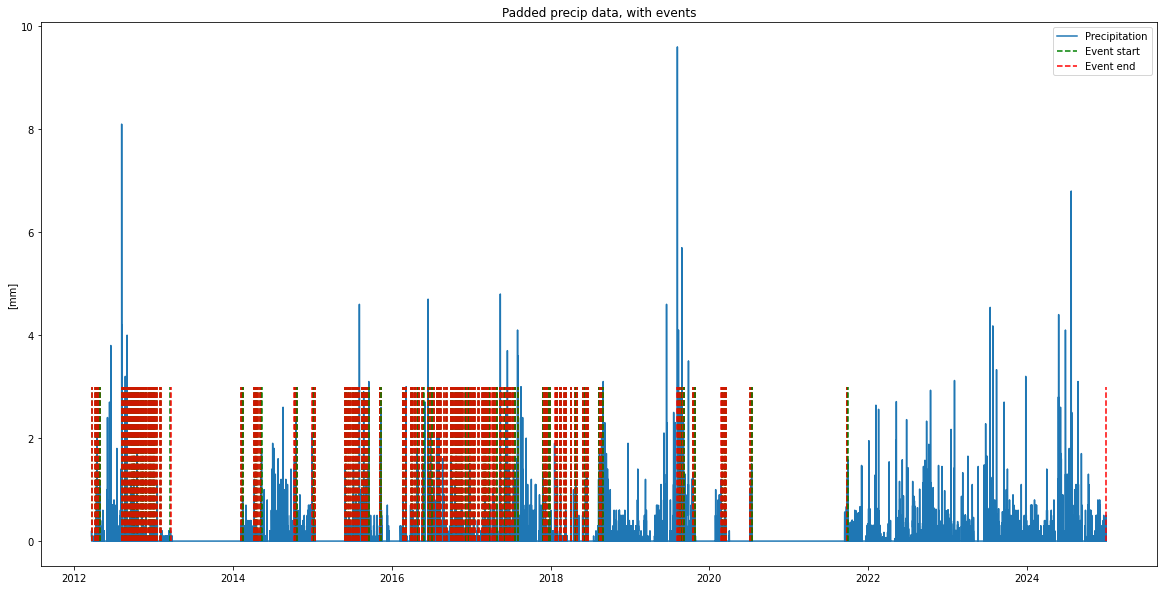

In [3]:
ts.plot_all_events()

In [5]:
events=ts.events
events

[(Timestamp('2012-03-19 23:20:00', freq='5T'),
  Timestamp('2012-03-20 03:10:00')),
 (Timestamp('2012-04-06 01:50:00'), Timestamp('2012-04-06 05:30:00')),
 (Timestamp('2012-04-09 01:15:00'), Timestamp('2012-04-09 12:40:00')),
 (Timestamp('2012-04-09 15:45:00'), Timestamp('2012-04-10 01:40:00')),
 (Timestamp('2012-04-10 03:00:00'), Timestamp('2012-04-10 08:55:00')),
 (Timestamp('2012-04-11 05:10:00'), Timestamp('2012-04-11 07:00:00')),
 (Timestamp('2012-04-13 17:15:00'), Timestamp('2012-04-13 23:25:00')),
 (Timestamp('2012-04-14 15:25:00'), Timestamp('2012-04-14 15:55:00')),
 (Timestamp('2012-04-20 11:45:00'), Timestamp('2012-04-20 14:55:00')),
 (Timestamp('2012-04-21 22:05:00'), Timestamp('2012-04-21 23:20:00')),
 (Timestamp('2012-04-22 00:45:00'), Timestamp('2012-04-22 01:20:00')),
 (Timestamp('2012-04-22 02:30:00'), Timestamp('2012-04-22 04:10:00')),
 (Timestamp('2012-04-24 21:50:00'), Timestamp('2012-04-24 23:25:00')),
 (Timestamp('2012-04-25 03:50:00'), Timestamp('2012-04-25 11:10:

In [57]:
def init_events(self, threshold):
    precip = self.data  # Assumes precip is a DataFrame with datetime index and 1 column
    
    ########################################
    ##### Prep: Calculate time step and rolling window
    
    # This calculates how many data points are in your threshold.
    # If your data is at 5-min intervals, then '11h' = 132 steps.
    ########################################
    
    time_delta = precip.index[1] - precip.index[0]
    threshold_minutes = pd.to_timedelta(threshold).total_seconds() / 60
    window_size = int(threshold_minutes // (time_delta.total_seconds() / 60))

    ########################################
    #####  2. Rolling sum and rolling count
    
    # Precip_sum converts the column to one showing the total precip in the last 11h
    # Valid count makes a column showing the number of valid precip vals in the last 11h (i.e. not NAN)
    ########################################    
    precip_sum = precip.rolling(window_size).sum()
    valid_count = precip.rolling(window_size).count()
    
    ########################################
    #####3. Find dry periods
    # These are the points that separate rainfall events.
    # This means: The previous 11 hours had no rain, and There were no NaNs in that window
    # That means: If there was rain just before this timestamp → it's a good place to mark the end of a rain event
                # If there is rain just after this timestamp → it's a good place to mark the start of a new event
    ########################################
    condition = (precip_sum == 0) & (valid_count == window_size)
    dates_w_zero_sum = condition.index[condition.values[:, 0]]
    
    ########################################
    #####4.  Find the first rainy timestep
    # This finds the first time it actually rained, to start your first event.
    ########################################    
    start_dates = []
    for date in precip.index:
        if precip.loc[date].values[0] != 0:
            start_dates = [date]
            break
            
    ########################################
    #####5. Loop through dry dates to split events
    # It works by looking both before and after each dry point
    # Before: If timestep directly before dry break has a non-zero 11-hour sum (i.e. it had rain before this dry gap), that implies a rain event just ended.
    # After: If timestep directly after dry break has a non-zero 11-hour sum, that means a new rain event has started.
    ########################################    
    # Identify event boundaries
    end_dates = []
    for date in tqdm(dates_w_zero_sum):
        # Look before this date, if there is rain
        if date - time_delta in precip.index and precip_sum.loc[date - time_delta].values[0] != 0:
            # Add an end date to the list of end dates
            end_dates += [date - pd.to_timedelta(threshold)]
        # look after tihs date, if there is rain
        if date + time_delta in precip.index and precip_sum.loc[date + time_delta].values[0] != 0:
            # Add a start date to the list of start dates
            start_dates += [date + time_delta]
            
    ########################################
    #####5. Loop through dry dates to split events
    # This loop is a safety net. It ensures that the final rain event actually has an end time.
    ########################################    
    # Add end of last event
    for date in reversed(precip.index):
        if precip.loc[date].values[0] != 0:
            end_dates += [date]
            break

    ########################################        
    #####6. Pair start and end dates into events
    # Zips up into tuples
    ########################################
    events = []
    for i in range(len(end_dates)):
        events += [(start_dates[i], end_dates[i])]

    self.events = events


2012-03-19 23:20:00


In [8]:
precip=ts.data

In [148]:
threshold='2h'
precip=ts.data
########################################
##### Prep: Calculate time step and rolling window

# This calculates how many data points are in your threshold.
# If your data is at 5-min intervals, then '11h' = 132 steps.
########################################
time_delta = precip.index[1] - precip.index[0]
threshold_minutes = pd.to_timedelta(threshold).total_seconds() / 60
window_size = int(threshold_minutes // (time_delta.total_seconds() / 60))

########################################
#####  2. Rolling sum and rolling count

# Precip_sum converts the column to one showing the total precip in the last 11h
# Valid count makes a column showing the number of valid precip vals in the last 11h (i.e. not NAN)
########################################    
precip_sum = precip.rolling(window_size).sum()
valid_count = precip.rolling(window_size).count()

########################################
#####3. Find dry periods
# These are the points that separate rainfall events.
# This means: The previous 11 hours had no rain, and There were no NaNs in that window
# That means: If there was rain just before this timestamp → it's a good place to mark the end of a rain event
            # If there is rain just after this timestamp → it's a good place to mark the start of a new event
########################################
condition = (precip_sum == 0) & (valid_count == window_size)
dates_w_zero_sum = condition.index[condition.values[:, 0]]

########################################
#####4.  Find the first rainy timestep
# This finds the first time it actually rained, to start your first event.
########################################    
start_dates = []
for date in precip.index:
    if precip.loc[date].values[0] != 0:
        start_dates = [date]
        break
        
########################################
#####5. Loop through dry dates to split events
# It works by looking both before and after each dry point
# Before: If timestep directly before dry break has a non-zero 11-hour sum (i.e. it had rain before this dry gap), that implies a rain event just ended.
# After: If timestep directly after dry break has a non-zero 11-hour sum, that means a new rain event has started.
########################################    
# Identify event boundaries
end_dates = []
for date in tqdm(dates_w_zero_sum):
    # Look before this date, if there is rain
    if date - time_delta in precip.index and precip_sum.loc[date - time_delta].values[0] != 0 and date + time_delta in precip.index and precip_sum.loc[date + time_delta].values[0] != 0:
        print("HELP")
        print(date)
    if date - time_delta in precip.index and precip_sum.loc[date - time_delta].values[0] != 0:
        end_dates += [date - pd.to_timedelta(threshold)]
    if date + time_delta in precip.index and precip_sum.loc[date + time_delta].values[0] != 0:
        start_dates += [date + time_delta]        

########################################
#####5. Loop through dry dates to split events
# This loop is a safety net. It ensures that the final rain event actually has an end time.
########################################    
# Add end of last event
for date in reversed(precip.index):
    if precip.loc[date].values[0] != 0:
        end_dates += [date]
        break

########################################        
#####6. Pair start and end dates into events
# Zips up into tuples
########################################
events = []
for i in range(len(end_dates)):
    events += [(start_dates[i], end_dates[i])]

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/pandas/core/window/rolling.py:1629: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  FutureWarning,
  4%|███▉                                                                                            | 13551/325272 [00:07<03:01, 1720.91it/s]

HELP
2012-05-12 08:05:00


  4%|████▏                                                                                           | 14086/325272 [00:07<02:56, 1758.12it/s]

HELP
2012-05-14 10:30:00


 12%|███████████▏                                                                                    | 38010/325272 [00:22<02:48, 1709.45it/s]

HELP
2012-09-09 07:25:00


 16%|███████████████▊                                                                                | 53668/325272 [00:31<02:33, 1766.65it/s]

HELP
2012-11-25 21:15:00


 17%|████████████████                                                                                | 54378/325272 [00:31<02:33, 1766.15it/s]

HELP
2012-11-29 21:10:00


 17%|████████████████▏                                                                               | 54909/325272 [00:31<02:34, 1755.15it/s]

HELP
2012-12-03 16:35:00
HELP
2012-12-03 21:00:00
HELP
2012-12-05 01:05:00


 18%|████████████████▉                                                                               | 57580/325272 [00:33<02:47, 1600.95it/s]

HELP
2012-12-17 06:30:00


 18%|█████████████████▎                                                                              | 58652/325272 [00:34<02:30, 1771.33it/s]

HELP
2012-12-22 11:50:00


 18%|█████████████████▍                                                                              | 59190/325272 [00:34<02:29, 1778.93it/s]

HELP
2012-12-26 06:40:00


 21%|████████████████████▍                                                                           | 69263/325272 [00:40<02:22, 1798.17it/s]

HELP
2013-02-07 01:00:00


 23%|█████████████████████▊                                                                          | 74098/325272 [00:42<02:21, 1779.48it/s]

HELP
2013-02-24 09:45:00


 24%|███████████████████████▎                                                                        | 79123/325272 [00:45<02:16, 1798.53it/s]

HELP
2013-03-16 22:05:00
HELP
2013-03-19 22:45:00


 60%|████████████████████████████████████████████████████████▉                                      | 195108/325272 [01:56<01:14, 1739.02it/s]

HELP
2014-12-30 22:00:00


 60%|█████████████████████████████████████████████████████████▎                                     | 196330/325272 [01:57<01:14, 1732.68it/s]

HELP
2015-01-06 23:10:00


 90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 292761/325272 [02:56<00:21, 1522.84it/s]

HELP
2019-03-07 18:20:00


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 325272/325272 [03:16<00:00, 1651.91it/s]


In [164]:
duration=4
window_length = 132
df=precip
df['precipitation (mm/hr)'] = df['Precip']/60
# Identify dry periods based on a precipitation threshold
df['is_dry'] = df['precipitation (mm/hr)'] < 0.1

# Calculate the rolling sum of precipitation over the specified window length
df['Rolling_Sum'] = df['Precip'].rolling(window=window_length).sum()
# Identify the end index of the window where the maximum total rainfall occurs
max_rainfall_end_index = df['Rolling_Sum'].idxmax()

if max_rainfall_end_index ==0:

    # Find the index of the maximum value in the 'Rolling_Sum' column
    max_rainfall_end_index = df['Rolling_Sum'].idxmax()

    # Create a copy of the original DataFrame or Series, and set the max value to NaN (or another placeholder)
    df_temp = df['Rolling_Sum'].copy()
    df_temp.loc[max_rainfall_end_index] = float('-inf')  # Set the max value to negative infinity

    # Find the index of the second-largest value
    max_rainfall_end_index = df_temp.idxmax()

# Convert index to a positional integer for slicing
max_rainfall_end_pos = df.index.get_loc(max_rainfall_end_index) 

# Calculate the start position of the window, ensuring it doesn't go below the DataFrame's range
max_rainfall_start_pos = max(0, max_rainfall_end_pos - window_length)

# Extract the window of maximum rainfall from the DataFrame
max_rainfall_window = df.iloc[max_rainfall_start_pos+1:max_rainfall_end_pos+1].copy()

################
# Remove leading and trailing zeroes????
################
max_rainfall_window

,Precip,precipitation(mm/hr),precipitation (mm/hr),is_dry,Rolling_Sum
2014-10-15 15:10:00,0.1,0.001667,0.001667,True,15.6
2014-10-15 15:15:00,0.1,0.001667,0.001667,True,15.6
2014-10-15 15:20:00,0.1,0.001667,0.001667,True,15.6
2014-10-15 15:25:00,0.2,0.003333,0.003333,True,15.7
2014-10-15 15:30:00,0.2,0.003333,0.003333,True,15.8
...,...,...,...,...,...
2014-10-16 01:45:00,0.9,0.015000,0.015000,True,79.1
2014-10-16 01:50:00,1.7,0.028333,0.028333,True,80.8
2014-10-16 01:55:00,1.4,0.023333,0.023333,True,82.2
2014-10-16 02:00:00,1.0,0.016667,0.016667,True,83.1


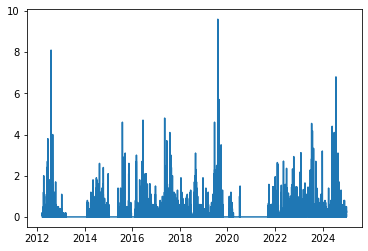

In [152]:
# Determine the length of the window based on provided duration
window_length = int(duration * 2)

# Identify dry periods based on a precipitation threshold
df['is_dry'] = df['precipitation (mm/hr)'] < 0.1

# Calculate the rolling sum of precipitation over the specified window length
df['Rolling_Sum'] = df['precipitation (mm)'].rolling(window=window_length).sum()

# Identify the end index of the window where the maximum total rainfall occurs
max_rainfall_end_index = df['Rolling_Sum'].idxmax()

if max_rainfall_end_index ==0:

    # Find the index of the maximum value in the 'Rolling_Sum' column
    max_rainfall_end_index = df['Rolling_Sum'].idxmax()

    # Create a copy of the original DataFrame or Series, and set the max value to NaN (or another placeholder)
    df_temp = df['Rolling_Sum'].copy()
    df_temp.loc[max_rainfall_end_index] = float('-inf')  # Set the max value to negative infinity

    # Find the index of the second-largest value
    max_rainfall_end_index = df_temp.idxmax()

# Convert index to a positional integer for slicing
max_rainfall_end_pos = df.index.get_loc(max_rainfall_end_index) 

# Calculate the start position of the window, ensuring it doesn't go below the DataFrame's range
max_rainfall_start_pos = max(0, max_rainfall_end_pos - window_length)

# Extract the window of maximum rainfall from the DataFrame
max_rainfall_window = df.iloc[max_rainfall_start_pos+1:max_rainfall_end_pos+1].copy()

################
# Remove leading and trailing zeroes????
################
print(f"len of full {duration}h window before trimming:" , len(max_rainfall_window))
max_rainfall_window = remove_leading_and_trailing_zeroes(max_rainfall_window)
print(f"len of full {duration}h window after trimming:" , len(max_rainfall_window))

In [146]:
test = precip_df[79900:80050]
test.to_csv("test.csv")

In [7]:
# precip_df = pd.DataFrame({'precip':precip['Precip'], 'precip_sum': precip_sum['Precip']})
# test = precip_df[80000:80050]

In [6]:
# condition = (precip_sum == 0)
# condition[condition['Precip']==True][37400:37459]

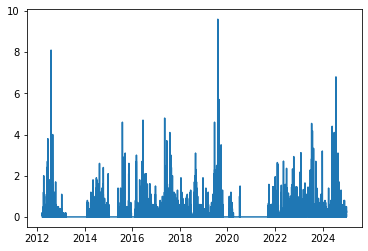

In [117]:
plt.plot(precip)

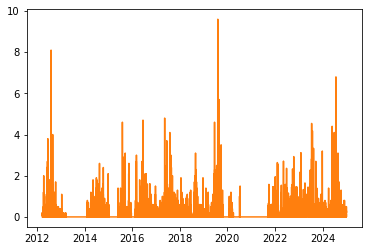

In [80]:
plt.plot(precip.iloc[80000:80350])
plt.plot(precip)

In [63]:
dates_w_zero_sum[37400:37450]

DatetimeIndex(['2012-11-05 00:10:00', '2012-11-05 00:15:00',
               '2012-11-05 00:20:00', '2012-11-05 00:25:00',
               '2018-08-10 12:55:00', '2018-08-11 02:00:00',
               '2018-08-11 02:05:00', '2018-08-11 02:10:00',
               '2018-08-11 02:15:00', '2018-08-11 02:20:00',
               '2018-08-11 02:25:00', '2018-08-11 02:30:00',
               '2018-08-11 02:35:00', '2018-08-11 02:40:00',
               '2018-08-11 02:45:00', '2018-08-11 02:50:00',
               '2018-08-11 02:55:00', '2018-08-11 03:00:00',
               '2018-08-11 03:05:00', '2018-08-11 21:05:00',
               '2018-08-11 21:10:00', '2018-08-11 21:15:00',
               '2018-08-11 21:20:00', '2018-08-11 21:25:00',
               '2018-08-11 21:30:00', '2018-08-11 21:35:00',
               '2018-08-11 21:40:00', '2018-08-11 21:45:00',
               '2018-08-11 21:50:00', '2018-08-11 21:55:00',
               '2018-08-11 22:00:00', '2018-08-11 22:05:00',
               '2018-08-

In [47]:
date

Timestamp('2024-12-31 23:20:00', freq='5T')

In [46]:
date - time_delta

Timestamp('2024-12-31 23:15:00', freq='5T')

In [18]:
## Get examples for one event
event_idx  = 12
for event_idx in range(0,131):
    event = ts.return_specific_event(event_idx)
    print(event_idx, event.isna().any()[0], len(event))


0 False 61
1 False 45
2 False 437
3 False 40
4 False 75
5 False 31
6 False 93
7 False 107
8 False 191
9 False 183
10 False 12
11 False 88
12 False 54
13 False 135
14 False 34
15 False 124
16 False 19
17 False 2752
18 False 36
19 False 89
20 False 46
21 False 81
22 False 11
23 False 292
24 False 52
25 False 45
26 False 84
27 False 30
28 False 108
29 False 14
30 False 146
31 False 106
32 False 77
33 False 51
34 False 66
35 False 28
36 False 18
37 False 49
38 False 12
39 False 112
40 False 70
41 False 15
42 False 15
43 False 53
44 False 41
45 False 97
46 False 58
47 False 27
48 False 28
49 False 42
50 False 64
51 False 124
52 False 43
53 False 155
54 False 128
55 False 93
56 False 77
57 False 60
58 False 84
59 False 119
60 False 177
61 False 258
62 False 110
63 False 237
64 False 476
65 False 142
66 False 75
67 False 22
68 False 43
69 False 243
70 False 74
71 False 39
72 False 83
73 False 36
74 False 83
75 False 427
76 False 240
77 False 182
78 False 61
79 False 268
80 False 100
81 False 

In [ ]:
precip_col = precip.columns[0]  # Assuming single column
time_delta = precip.index[1] - precip.index[0]

# Rolling window to detect dry periods
precip_sum = precip.rolling(threshold).sum()
dry_mask = (precip_sum[precip_col] == 0)

in_event = False
events = []
start = None

for i in range(len(precip)):
    current_time = precip.index[i]
    value = precip.iloc[i][precip_col]

    if not in_event and value > 0:
        # Start of a new event
        in_event = True
        start = current_time

    elif in_event:
        # Check if next window is dry
        if i >= threshold and dry_mask.iloc[i]:
            end = precip.index[i - threshold + 1]
            events.append((start, end))
            in_event = False

# Add final event if still in one
if in_event:
    events.append((start, precip.index[-1]))



In [ ]:
threshold = '11h'
precip_df = pd.read_csv("/nfs/a319/gy17m2a/PhD/datadir/DanishRainData/532020_precip_minute_edited.csv", encoding="ISO-8859-1",index_col=0)
precip_df.index = pd.to_datetime(precip_df.index)
precip = precip_df['Precip'].values

time_delta = precip_df.index[1] - precip_df.index[0]

# Rolling 11-hour sum
precip_sum = precip_df['Precip'].rolling(threshold).sum()

# Dates with no precip in the last 11 hours
dates_w_zero_sum = precip_sum.index[(precip_sum.mask(precip_sum != 0) == precip_sum).values[:, 0]]

# Add first date with rain
start_dates = []
for date in precip.index:
    if precip.loc[date].values[0] != 0:
        start_dates = [date]
        break

# Save start and end dates
end_dates = []
for date in tqdm(dates_w_zero_sum):
    # Ensure we're not trying to access out-of-bounds indices
    if date - time_delta in precip.index and precip_sum.loc[date - time_delta].values[0] != 0:
        end_dates += [date - pd.to_timedelta(threshold)]
    if date + time_delta in precip.index and precip_sum.loc[date + time_delta].values[0] != 0:
        start_dates += [date + time_delta]

# Add end to last event
for date in reversed(precip.index):  # Iterate from last to first
    if precip.loc[date].values[0] != 0:  # Check if value is not zero
        end_dates += [date]
        break  # Stop at the first nonzero value

# Save events as list of tuples
events = []
for i in range(len(end_dates)):
    events += [(start_dates[i], end_dates[i])]



In [ ]:
# del all_events_df['min_intensity']
# del all_events_df['BSC']

In [ ]:
corr_matrix = all_events_df.corr()

In [ ]:
# from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
# from scipy.spatial.distance import squareform

# plt.figure(figsize=(12,5))
# dissimilarity = 1 - abs(corr_matrix)
# Z = linkage(squareform(dissimilarity), 'complete')

# dendrogram(Z, labels=df.columns, orientation='top', 
#            leaf_rotation=90);

In [ ]:
# Clusterize the data
threshold = 0.8
labels = fcluster(Z, threshold, criterion='distance')

In [ ]:
# Keep the indices to sort labels
labels_order = np.argsort(labels)

# Build a new dataframe with the sorted columns
for idx, i in enumerate(df.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(df[i])
    else:
        df_to_append = pd.DataFrame(df[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

In [ ]:
# Compute correlation matrix
corr_matrix = corr_matrix

# Create the plot
plt.figure(figsize=(20, 15))

# Mask the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create heatmap
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=False, fmt=".2f", 
            linewidths=0.5, cbar=True, xticklabels=True, yticklabels=True)

# Improve layout
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.yticks(rotation=0)  # Ensure y-axis labels are readable
plt.tight_layout()

In [214]:
def find_rainfall_core(df, duration, Tb0):
    """
    Analyzes rainfall data to find the core period of rainfall and checks for independence of the event.
    
    Args:
    df (pd.DataFrame): DataFrame containing precipitation data.
    duration (float): The duration over which to calculate the rolling sum, in hours.
    Tb0 (float): Threshold used to define a 'dry' period for splitting events.
    
    Returns:
    list: A list containing either one or two DataFrames, depending on whether the rainfall event splits.
    """

    ################
    # Find window of dataframe which has max rainfall accumulation for this duration
    ################
    
    # Determine the length of the window based on provided duration
    window_length = int(duration * 2)

    # Identify dry periods based on a precipitation threshold
    df['is_dry'] = df['precipitation (mm/hr)'] < 0.1

    # Calculate the rolling sum of precipitation over the specified window length
    df['Rolling_Sum'] = df['precipitation (mm)'].rolling(window=window_length).sum()

    # Identify the end index of the window where the maximum total rainfall occurs
    max_rainfall_end_index = df['Rolling_Sum'].idxmax()

    if max_rainfall_end_index ==0:

        # Find the index of the maximum value in the 'Rolling_Sum' column
        max_rainfall_end_index = df['Rolling_Sum'].idxmax()

        # Create a copy of the original DataFrame or Series, and set the max value to NaN (or another placeholder)
        df_temp = df['Rolling_Sum'].copy()
        df_temp.loc[max_rainfall_end_index] = float('-inf')  # Set the max value to negative infinity

        # Find the index of the second-largest value
        max_rainfall_end_index = df_temp.idxmax()

    # Convert index to a positional integer for slicing
    max_rainfall_end_pos = df.index.get_loc(max_rainfall_end_index) 

    # Calculate the start position of the window, ensuring it doesn't go below the DataFrame's range
    max_rainfall_start_pos = max(0, max_rainfall_end_pos - window_length)

    # Extract the window of maximum rainfall from the DataFrame
    max_rainfall_window = df.iloc[max_rainfall_start_pos+1:max_rainfall_end_pos+1].copy()

    ################
    # Remove leading and trailing zeroes????
    ################
    print(f"len of full {duration}h window before trimming:" , len(max_rainfall_window))
    max_rainfall_window = remove_leading_and_trailing_zeroes(max_rainfall_window)
    print(f"len of full {duration}h window after trimming:" , len(max_rainfall_window))
    
    ################
    # Check whether this is one independent event, or two
    ################
    # Initialize a column to keep track of consecutive dry periods within the window
    max_rainfall_window['consecutive_dry'] = 0

    # Iterate through the rows of the extracted window to count consecutive dry periods
    consecutive_dry_count = 0
    for i in range(len(max_rainfall_window)):
        if max_rainfall_window.iloc[i]['is_dry']:
            consecutive_dry_count += 1
        else:
            consecutive_dry_count = 0
        max_rainfall_window.iloc[i, max_rainfall_window.columns.get_loc('consecutive_dry')] = consecutive_dry_count
    
    # Check if the maximum consecutive dry period exceeds twice the Tb0 threshold
    if np.nanmax(max_rainfall_window['consecutive_dry']) > Tb0 * 2 :
        print('2 events')
        split_index = max_rainfall_window[max_rainfall_window['consecutive_dry'] == (Tb0 * 2)].index[0]
        
        event1 = max_rainfall_window.loc[:split_index]
        event2 = max_rainfall_window.loc[split_index:]
        print('Before trimming: event1 is ', len(event1), ', event2 is ', len(event2))
        
        event1 = remove_leading_and_trailing_zeroes(event1)
        event2 = remove_leading_and_trailing_zeroes(event2)
        print('After trimming: event1 is ', len(event1), ', event2 is ', len(event2))
        return [event1, event2]
    else:
        print("1 event", len(max_rainfall_window))
        return [max_rainfall_window]
 

def find_all_rainfall_cores(df, duration, Tb0, rain_threshold=1.0):
    """
    Finds all rainfall core periods based on rolling accumulation and dryness criteria.
    
    Args:
    - df (pd.DataFrame): DataFrame with datetime index and 'precipitation (mm)' column.
    - duration (float): Duration of rolling window in hours.
    - Tb0 (float): Dry spell threshold for event independence.
    - rain_threshold (float): Minimum rainfall in a core window to consider it a valid event.
    
    Returns:
    - list of DataFrames, each representing a rainfall core event.
    """

    df = df.copy()
    df['is_dry'] = df['precipitation (mm/hr)'] < 0.001
    window_length = int(duration * 2)  # 2 values per hour for 30-min frequency

    # Rolling rainfall sum
    df['Rolling_Sum'] = df['precipitation (mm)'].rolling(window=window_length, min_periods=window_length).sum()

    # Identify candidate windows where rainfall exceeds threshold
    is_core = df['Rolling_Sum'] > rain_threshold
    df['is_core'] = is_core

    # Group contiguous core windows into distinct cores
    df['core_group'] = (df['is_core'] != df['is_core'].shift()).cumsum()
    core_windows = []

    for group_id, group in df.groupby('core_group'):
        if group['is_core'].iloc[0]:  # Only keep actual core groups
            core_df = group.dropna(subset=['Rolling_Sum'])

            # Trim to rolling window
            end_idx = core_df.index[-1]
            start_idx = end_idx - pd.Timedelta(hours=duration)
            core_slice = df.loc[start_idx:end_idx].copy()

            # Trim outer zeroes
            core_slice = remove_leading_and_trailing_zeroes(core_slice)

            # Check for independence (long dry gap)
            core_slice['consecutive_dry'] = (core_slice['is_dry']
                                             .astype(int)
                                             .groupby((~core_slice['is_dry']).cumsum())
                                             .cumsum())

            max_dry = core_slice['consecutive_dry'].max()
            if max_dry > Tb0 * 2:
                # Split event
                split_idx = core_slice[core_slice['consecutive_dry'] >= Tb0 * 2].index[0]
                event1 = core_slice.loc[:split_idx]
                event2 = core_slice.loc[split_idx:]
                event1 = remove_leading_and_trailing_zeroes(event1)
                event2 = remove_leading_and_trailing_zeroes(event2)
                if not event1.empty:
                    core_windows.append(event1)
                if not event2.empty:
                    core_windows.append(event2)
            else:
                core_windows.append(core_slice)

    return core_windows

    
def search1(df, max_rainfall_window):
    
    ######## Forewards
    # Find the ending index of max_rainfall_window
    end_index_position = df.index.get_loc(max_rainfall_window.last_valid_index())

    # Initialize a variable to keep track of the current position being checked
    current_position = end_index_position + 1  # Start from the row just after the max_rainfall_window

    # Iterate forward through the DataFrame from the end of the max_rainfall_window
    while current_position < len(df):
        # Get the row at the current position
        row_by_position_df = df.iloc[current_position:current_position+1]
        #print(f"Checking row at position {current_position}:")
        #print(row_by_position_df)

        # Check if the row is dry
        if row_by_position_df['precipitation (mm)'].values[0]>0.2:
            # If the row is dry, append it to max_rainfall_window
            # print("foreward")
            max_rainfall_window = pd.concat([max_rainfall_window, row_by_position_df], axis=0)
        else:
            #print("Row is wet. Stopping the search.")
            # If the row is wet, stop the search
            break

        # Move to the next row to check
        current_position += 1
    max_rainfall_window

    ######## Backwards
    # Find the starting index of max_rainfall_window
    start_index = max_rainfall_window.first_valid_index()

    # Initialize a variable to keep track of the current position being checked
    current_position = start_index - 1  # Start from the row just before the max_rainfall_window

    # Iterate backwards through the DataFrame from the start of the max_rainfall_window
    while current_position >= 0:
        # Get the row at the current position
        row_by_position_df = df.iloc[current_position:current_position+1]
        #print(f"Checking row at position {current_position}:")

        # Check if the row is dry
        if row_by_position_df['precipitation (mm)'].values[0]>0.2:
            # If the row is dry, append it to max_rainfall_window
            max_rainfall_window = pd.concat([row_by_position_df, max_rainfall_window], axis=0)
            #print('Row is dry. Including it in the window.')
        else:
            #print(f"{current_position}, less than 0.2mm/hr, stopping search")
            break

        # Move to the next row to check
        current_position -= 1
    return max_rainfall_window
    

def search2(df, max_rainfall_window):
    #### Foreward search
    # Find the ending index of max_rainfall_window
    end_index_position = df.index.get_loc(max_rainfall_window.last_valid_index())

    # Initialize a variable to keep track of the current position being checked
    current_position = end_index_position + 1  # Start from the row just after the max_rainfall_window

    # Iterate forward through the DataFrame from the end of the max_rainfall_window
    while current_position < len(df):
        # Get the row at the current position
        row_by_position_df = df.iloc[current_position:current_position+2]
        #print(f"Checking row at position {current_position}:")
        #print(row_by_position_df)

        if row_by_position_df['precipitation (mm)'].sum() > 0.4:
            max_rainfall_window = pd.concat([max_rainfall_window, row_by_position_df], axis=0)
        else:
            #print("Row is wet. Stopping the search.")
            # If the row is wet, stop the search
            break

        # Move to the next row to check
        current_position += 2
    
    #### Backward search
    # Find the starting index of max_rainfall_window
    start_index = max_rainfall_window.first_valid_index()

    # Initialize a variable to keep track of the current position being checked
    current_position = start_index - 1  # Start from the row just before the max_rainfall_window

    # Iterate backwards through the DataFrame from the start of the max_rainfall_window
    while current_position >= 0:
        # Get the row at the current position
        row_by_position_df = df.iloc[current_position:current_position+1]
        #print(f"Checking row at position {current_position}:")
        #print(row_by_position_df)

        # Check if the row is dry
        if row_by_position_df['precipitation (mm)'].sum() > 0.4:
            max_rainfall_window = pd.concat([row_by_position_df, max_rainfall_window], axis=0)
            #print('Row is dry. Including it in the window.')
        else:
            # print("Row is wet. Stopping the search.")
            # If the row is wet, stop the search
            break

        # Move to the next row to check
        current_position -= 2    
        
    return max_rainfall_window



def search3(df, max_rainfall_window, Tb0):
    
    '''
    Searches for any rainfall values within Tbo of the last rainfall value currently included, 
    and if any of these have a rainfall value >1mm/hr then the intervening values up to the occurrence of this value 
    are included
    '''
    
    #### Backwards search
    start_index = max_rainfall_window.first_valid_index()
    backward_position = start_index - Tb0*2

    while backward_position >= 0:
        # Get the data in the Tb0 before the start of the event core
        backward_slice = df.iloc[backward_position:start_index]
        # If any values are over 1, then 
        if (backward_slice['precipitation (mm/hr)'] > 1).any():
            # Find the index of the earliest row where this is true (precip mm/hr is over 1)
            first_true_index = (backward_slice['precipitation (mm/hr)'] > 1).idxmax()
            # Join this to the rainfall event 
            max_rainfall_window = pd.concat([df.loc[first_true_index:start_index-1], max_rainfall_window], axis=0)
            # Update the start index for further searches if needed 
            start_index = first_true_index 
            backward_position = start_index - Tb0*2  # Update the backward search position
        else:
            break  # Exit the loop if no such condition is met

    ### Foreward search: from the end of the existing max_rainfall_window
    end_index = max_rainfall_window.last_valid_index()

    while end_index < len(df):
        # Tracks the current position of where the forward search is starting from
        # e.g. (the row afer the max_rainfall_window)
        forward_search_start_position = end_index + 1
        # and ending from (e.g. 2*Tb0 after where it starts)
        forward_search_end_position = min(len(df), forward_search_start_position + (Tb0*2))  # Define the limit for forward search
        # Get the forward slice
        forward_slice = df.iloc[forward_search_start_position:forward_search_end_position]
        # Check for rows meeting the condition (> 1 mm/hr)
        condition_met = forward_slice['precipitation (mm/hr)'] > 1
        if condition_met.any():
            # Identify the last index where the condition is True
            last_true_index = condition_met[condition_met].index[-1]
            rows_to_add = df.loc[end_index+1:last_true_index]
            max_rainfall_window = pd.concat([max_rainfall_window, rows_to_add], axis=0)
        else:
            break

        # Update the end index
        end_index = max_rainfall_window.last_valid_index()
    
    return max_rainfall_window

def find_amax_indy_events_v2(df, duration, Tb0, gauge_num, yr):
    rainfall_cores = find_rainfall_core(df, duration=duration, Tb0=Tb0)
    rainfall_events_expanded = []

    for rainfall_core in rainfall_cores:
        rainfall_core_after_search1 = search1(df, rainfall_core)
        rainfall_core_after_search2 = search2(df, rainfall_core_after_search1)
        rainfall_core_after_search3 = search3(df, rainfall_core_after_search2, Tb0=Tb0)
        if len(rainfall_core_after_search3[rainfall_core_after_search3['precipitation (mm/hr)'] > 0.1]) > 0:
            rainfall_events_expanded.append(rainfall_core_after_search3)
    
    # Collect all 'times' values from each DataFrame
    all_times = pd.Series(dtype='datetime64[ns]')  # Create an empty series with datetime type
    all_times = pd.concat([all_times] + [a_df['times'] for a_df in rainfall_events_expanded], ignore_index=True)

    # Check for duplicates and raise an exception if any are found
    if all_times.duplicated().any():
        raise ValueError(f"Overlapping times detected in the DataFrames {gauge_num}, {duration} {yr} {rainfall_events_expanded[0]} {rainfall_events_expanded[1]},{rainfall_cores[0]} {rainfall_cores[1]} {all_times}")
    else:
        print(f"No overlapping times {gauge_num}, {duration} {yr}")
    
        return rainfall_events_expanded
    
def remove_leading_and_trailing_zeroes(df, threshold = 0.05):
    
    # Identify the start and end of the event where values are above the threshold
    event_start = df[df['precipitation (mm)'] >= threshold].index.min()
    event_end = df[df['precipitation (mm)'] >= threshold].index.max()

    # Handle cases where no values are above the threshold
    if pd.isna(event_start) or pd.isna(event_end):
        print(df)
        print("No events found with precipitation >= threshold.")
    else:
        # Remove values < threshold from the start and end of the event
        trimmed_test = df.loc[event_start:event_end]#.reset_index(drop=True)
    
    return trimmed_test 

def find_all_rainfall_cores(df, duration, Tb0):
    """
    Analyzes rainfall data to find all core periods of rainfall and checks for independence of the event.

    Args:
    df (pd.DataFrame): DataFrame containing precipitation data.
    duration (float): The duration over which to calculate the rolling sum, in hours.
    Tb0 (float): Threshold used to define a 'dry' period for splitting events.

    Returns:
    list: A list of DataFrames, each representing a core rainfall event or split event.
    """
    window_length = int(duration * 2)
    df = df.copy()
    df['is_dry'] = df['precipitation (mm/hr)'] < 0.1
    df['Rolling_Sum'] = df['precipitation (mm)'].rolling(window=window_length).sum()

    # Filter out windows where Rolling_Sum is NaN or 0
    valid_windows = df.dropna(subset=['Rolling_Sum'])
    valid_windows = valid_windows[valid_windows['Rolling_Sum'] > 0]

    # Get the list of valid end indices
    end_indices = valid_windows.index

    all_events = []

    for end_idx in end_indices:
        end_pos = df.index.get_loc(end_idx)
        start_pos = max(0, end_pos - window_length)
        event_window = df.iloc[start_pos + 1:end_pos + 1].copy()

        print(f"\nlen of full {duration}h window before trimming:" , len(event_window))
        event_window = remove_leading_and_trailing_zeroes(event_window)
        print(f"len of full {duration}h window after trimming:" , len(event_window))

        # Initialize a column to keep track of consecutive dry periods
        event_window['consecutive_dry'] = 0
        consecutive_dry_count = 0
        for i in range(len(event_window)):
            if event_window.iloc[i]['is_dry']:
                consecutive_dry_count += 1
            else:
                consecutive_dry_count = 0
            event_window.iloc[i, event_window.columns.get_loc('consecutive_dry')] = consecutive_dry_count

        # Split event if dry spell exceeds threshold
        if np.nanmax(event_window['consecutive_dry']) > Tb0 * 2:
            print('2 events')
            split_index = event_window[event_window['consecutive_dry'] == (Tb0 * 2)].index[0]
            event1 = remove_leading_and_trailing_zeroes(event_window.loc[:split_index])
            event2 = remove_leading_and_trailing_zeroes(event_window.loc[split_index:])
            print('After trimming: event1 is ', len(event1), ', event2 is ', len(event2))
            all_events.extend([event1, event2])
        else:
            print("1 event", len(event_window))
            all_events.append(event_window)

    return all_events


In [174]:
precip.rename(columns={'Precip':'precipitation (mm)'}, inplace=True)

In [215]:
rainfall_cores = find_all_rainfall_cores(precip, duration=duration, Tb0=11)
len(rainfall_cores)


len of full 4h window before trimming: 7
                     precipitation (mm)  precipitation(mm/hr)  \
2012-03-19 23:25:00                 0.0                   0.0   
2012-03-19 23:30:00                 0.0                   0.0   
2012-03-19 23:35:00                 0.0                   0.0   
2012-03-19 23:40:00                 0.0                   0.0   
2012-03-19 23:45:00                 0.0                   0.0   
2012-03-19 23:50:00                 0.0                   0.0   
2012-03-19 23:55:00                 0.0                   0.0   

                     precipitation (mm/hr)  is_dry  Rolling_Sum  
2012-03-19 23:25:00                    0.0    True          NaN  
2012-03-19 23:30:00                    0.0    True          NaN  
2012-03-19 23:35:00                    0.0    True          NaN  
2012-03-19 23:40:00                    0.0    True          NaN  
2012-03-19 23:45:00                    0.0    True          NaN  
2012-03-19 23:50:00                    0.

UnboundLocalError: local variable 'trimmed_test' referenced before assignment

In [204]:
len(rainfall_cores)

1612

In [205]:
new_rainfall_cores =[]
for rainfall_core in rainfall_cores:
    if len(rainfall_core)>10:
        new_rainfall_cores.append(rainfall_core)
len(new_rainfall_cores)        

1253

49

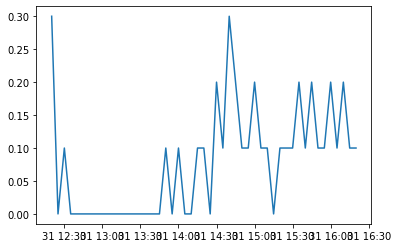

In [206]:
event_idx=100
plt.plot(new_rainfall_cores[event_idx].index, new_rainfall_cores[event_idx]['precipitation (mm)'])
len(new_rainfall_cores[event_idx])

In [210]:
for core in new_rainfall_cores:
    print(core.index[0])

2012-04-09 15:45:00
2012-04-10 03:40:00
2012-04-13 20:05:00
2012-04-14 13:25:00
2012-04-21 22:05:00
2012-04-22 00:45:00
2012-04-25 05:10:00
2012-04-26 12:35:00
2012-04-26 12:35:00
2012-04-27 10:55:00
2012-05-08 17:45:00
2012-05-08 19:30:00
2012-05-08 19:30:00
2012-05-09 08:30:00
2012-05-10 06:15:00
2012-05-10 08:50:00
2012-05-10 09:55:00
2012-05-11 00:15:00
2012-05-29 01:20:00
2012-06-01 09:10:00
2012-06-08 12:50:00
2012-06-09 21:40:00
2012-06-10 12:00:00
2012-06-10 13:55:00
2012-06-15 19:40:00
2012-06-16 12:25:00
2012-06-16 15:00:00
2012-06-22 12:40:00
2012-06-24 13:10:00
2012-06-25 06:05:00
2012-06-25 09:25:00
2012-07-01 04:30:00
2012-07-01 04:30:00
2012-07-01 04:30:00
2012-07-06 11:45:00
2012-07-14 07:05:00
2012-07-14 17:10:00
2012-07-16 01:20:00
2012-07-28 09:35:00
2012-08-02 12:15:00
2012-08-04 18:35:00
2012-08-06 06:35:00
2012-08-18 00:30:00
2012-08-22 06:05:00
2012-08-22 23:50:00
2012-08-23 01:40:00
2012-08-24 09:05:00
2012-08-25 14:35:00
2012-08-25 14:35:00
2012-09-06 14:55:00
